In [13]:
### EP2 MAC0417 / MAC5768
###################################################################
# AO PREENCHER ESSE CABEÇALHO COM O MEU NOME E O MEU NÚMERO USP,  #
# DECLARO QUE SOU O ÚNICO AUTOR E RESPONSÁVEL PELA RESOLUÇÃO      #
# DESTE EP.                                                       #
# TODAS AS PARTES FORAM DESENVOLVIDAS E IMPLEMENTADAS POR MIM,    #
# SEGUINDO AS INSTRUÇÕES E QUE PORTANTO, NÃO CONSTITUEM           #
# DESONESTIDADE ACADÊMICA OU PLÁGIO.                              #
#                                                                 #
# DECLARO TAMBÉM, QUE SOU RESPONSÁVEL POR TODAS AS CÓPIAS         #
# DESSE PROGRAMA, E QUE EU NÃO DISTRIBUI OU FACILITEI A           #
# SUA DISTRIBUIÇÃO. ESTOU CIENTE QUE OS CASOS DE PLÁGIO E         #
# DESONESTIDADE ACADÊMICA SERÃO TRATADOS SEGUNDO OS CRITÉRIOS     #
# DEFINIDOS NO CÓDIGO DE ÉTICA DA USP.                            #
#                                                                 #
# ENTENDO QUE JUPYTER NOTEBOOKS SEM ASSINATURA NÃO SERÃO          #
# CORRIGIDOS E, AINDA ASSIM, PODERÃO SER PUNIDOS POR              #
# DESONESTIDADE ACADÊMICA.                                        #
#                                                                 #
#                                                                 #
# Nome : Caio Dantas Simao Ugeda                                  #
# NUSP : 11796868                                                 #
# Turma: 2024                                                     #
# Prof.: Ronaldo                                                  #
###################################################################

In [14]:
from os import listdir, stat, makedirs
from os.path import isfile, join, getsize, exists
import pandas as pd
import numpy as np
from matplotlib.image import imread
import matplotlib.pyplot as plt
from cv2 import resize, imwrite
import cv2 as cv2

# Helpers

In [15]:
def save_images(images, path):
  for filename, image in images:
    imwrite(join(path, filename), image)

In [16]:
def plot_images(title, images):
  columns = len(images)
  i = 0
  for _, img in images:
    plt.subplot(len(images) // columns + 1, columns, i + 1)
    plt.axis('off')
    plt.imshow(img, cmap='gray')
    i += 1
  plt.suptitle(title)
  plt.show()

In [17]:
def rescale(img, max = 255):
  return ((img - np.min(img)) / np.max(img - np.min(img))) * np.max(max)

In [18]:
def apply_kernel_to_image(image, kernel):
  rows, cols = image.shape
  output = np.zeros_like(image)
  pad_width = len(kernel) // 2
  padded_image = np.pad(image, pad_width=pad_width, mode='constant', constant_values=0)

  for i in range(1, rows + 1):
      for j in range(1, cols + 1):
          region = padded_image[i-1:i+2, j-1:j+2]
          output[i-1, j-1] = np.sum(region * kernel)
  return output

# Metadata

In [19]:
df = pd.read_csv('./metadata.csv')

classesDict = {}
backgroundDict = {}
lightDict = {}

for idx, row in df.iterrows():
  if backgroundDict.get(row['fundo']) is None:
      backgroundDict[row['fundo']] = []
  if lightDict.get(row['luz']) is None:
      lightDict[row['luz']] = []
  backgroundDict[row['fundo']].append(row['imagem'])
  lightDict[row['luz']].append(row['imagem'])
  for classe in row['classes'].split(","):
    if classesDict.get(classe) is None:
      classesDict[classe] = []
    classesDict[classe].append(row['imagem'])

# Image Structure

In [20]:
IMG_PATH = './images'
IMG_PATH_REDUCED = './images_reduced'
DATASET_GRAY = './images_gray'
AUGMENTED_DATASET = './augmented_dataset'
AUGMENTED_DATASET_CONTRAST_STRETCH = './augmented_dataset/contraststretch'
AUGMENTED_DATASET_LOG = './augmented_dataset/log'
AUGMENTED_DATASET_EXPO = './augmented_dataset/expo'
AUGMENTED_DATASET_LAPLACE = './augmented_dataset/laplace'
AUGMENTED_DATASET_MEAN = './augmented_dataset/mean'

In [21]:
# Create dirs
if not exists(IMG_PATH_REDUCED):
  makedirs(IMG_PATH_REDUCED)
if not exists(AUGMENTED_DATASET):
  makedirs(AUGMENTED_DATASET)
if not exists(DATASET_GRAY):
  makedirs(DATASET_GRAY)
if not exists(AUGMENTED_DATASET_CONTRAST_STRETCH):
  makedirs(AUGMENTED_DATASET_CONTRAST_STRETCH)
if not exists(AUGMENTED_DATASET_LOG):
  makedirs(AUGMENTED_DATASET_LOG)
if not exists(AUGMENTED_DATASET_EXPO):
  makedirs(AUGMENTED_DATASET_EXPO)
if not exists(AUGMENTED_DATASET_LAPLACE):
  makedirs(AUGMENTED_DATASET_LAPLACE)
if not exists(AUGMENTED_DATASET_MEAN):
  makedirs(AUGMENTED_DATASET_MEAN)

# Resizing and converting to gray image

In [22]:
# Resize original (large) images -> resize them -> save to reduced images dir
for f in listdir(IMG_PATH):
  img = imread(join(IMG_PATH, f))
  img_redux = resize(img, (0,0), fx=0.35, fy=0.35)
  imwrite(join(IMG_PATH_REDUCED, f), img_redux)

In [23]:
# Read reduced images from path
files_reduced = [(f, imread(join(IMG_PATH_REDUCED, f))) for f in listdir(IMG_PATH_REDUCED)]

In [24]:
def RGB2gray(img):
  return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [25]:
files_reduced_gray = [(f, RGB2gray(img)) for f, img in files_reduced]
save_images(files_reduced_gray, DATASET_GRAY)

# Augmented functions

In [26]:
def contrast_stretch(image):
  return (image - np.min(image)) / (np.max(image) - np.min(image))*255

In [27]:
def log(image, c):
  c_log_image = c * np.log(1 + image.astype(float))
  c_log_resized = rescale(c_log_image, np.max(image))
  return c_log_resized

In [28]:
def exp(image, gamma, c):
  gamma_power_image = c * (image ** gamma)
  rescale_gamma_power = rescale(gamma_power_image, np.max(image))
  return rescale_gamma_power

In [29]:
def laplace(image):
  laplacian_kernel = np.array([[0,  1, 0],
                               [1, -4, 1],
                               [0,  1, 0]])
  output = apply_kernel_to_image(image, laplacian_kernel)
  return output

In [30]:
def mean(image):
  mean_kernel = np.ones((3, 3)) / 9

  output = apply_kernel_to_image(image, mean_kernel)
  return output

In [31]:
light_parameter_dict = {
    'interior claro': {
        'c': 4,
        'gamma': 0.8,
        'c_power': 1
    },
    'interior escuro': {
        'c': 10,
        'gamma': 0.3,
        'c_power': 1
    },
    'exterior claro': {
        'c': 1,
        'gamma': 1,
        'c_power': 1
    },
    'exterior escuro': {
        'c': 5,
        'gamma': 0.3,
        'c_power': 1
    },
}

def get_parameter_by_filename(filename):
  for light, images in lightDict.items():
    if filename in images:
      return light_parameter_dict[light]

In [32]:
contrast_stretched_images = [(filename, contrast_stretch(image)) for filename, image in files_reduced_gray]
save_images(contrast_stretched_images, AUGMENTED_DATASET_CONTRAST_STRETCH)

In [33]:
log_images = [(filename, log(image, get_parameter_by_filename(filename)['c'])) for filename, image in files_reduced_gray]
save_images(log_images, AUGMENTED_DATASET_LOG)

In [34]:
expo_images = [(filename, exp(image, get_parameter_by_filename(filename)['gamma'], get_parameter_by_filename(filename)['c_power'])) for filename, image in files_reduced_gray]
save_images(expo_images, AUGMENTED_DATASET_EXPO)

In [35]:
laplacian_images = [(filename, laplace(image)) for filename, image in files_reduced_gray]
save_images(laplacian_images, AUGMENTED_DATASET_LAPLACE)

In [36]:
mean_images = [(filename, mean(image)) for filename, image in files_reduced_gray]
save_images(mean_images, AUGMENTED_DATASET_MEAN)

# Displaying datasets

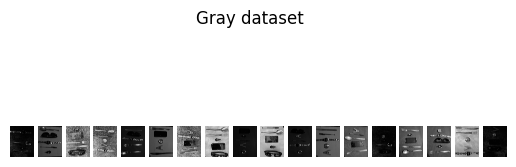

------------------------------------------------------------


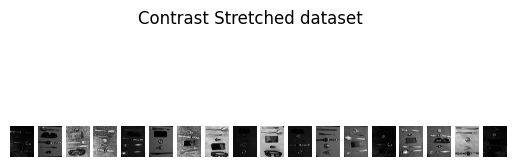

------------------------------------------------------------


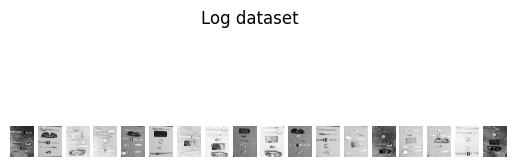

------------------------------------------------------------


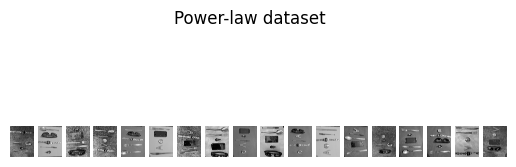

------------------------------------------------------------


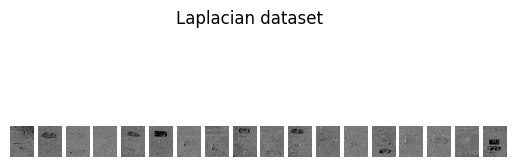

------------------------------------------------------------


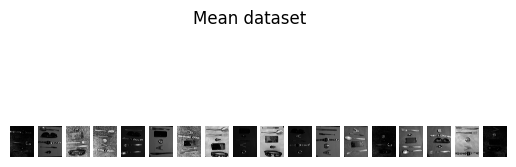

In [37]:
plot_images("Gray dataset", files_reduced_gray)
print("------------------------------------------------------------")
plot_images("Contrast Stretched dataset", contrast_stretched_images)
print("------------------------------------------------------------")
plot_images("Log dataset", log_images)
print("------------------------------------------------------------")
plot_images("Power-law dataset", expo_images)
print("------------------------------------------------------------")
plot_images("Laplacian dataset", laplacian_images)
print("------------------------------------------------------------")
plot_images("Mean dataset", mean_images)
